# Linear Regression, Leadtime Testing

Train a linear regression model to predict AMV at specified leadtimes.

Uses data that has been preprocessed by "output_normalized_data.ipynb"
in /Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import os
from numpy.linalg import inv

In [2]:
# User Edits
leads          = np.arange(0,25,1)    # Time ahead (in years) to forecast AMV
resolution     = '2deg'               # Resolution of input (2deg or full)
season         = 'Ann'                # Season to take mean over
indexregion    = 'NAT'                # One of the following ("SPG","STG","TRO","NAT")
outpath        = os.getcwd()

# Training/Testing Subsets
percent_train = 0.8   # Percentage of data to use for training (remaining for testing)
ens           = 40    # Ensemble members to use
channels      = 3

In [4]:
# Functions
def calc_AMV_index(region,invar,lat,lon):
    """
    Select bounding box for a given AMV region for an input variable
        "SPG" - Subpolar Gyre
        "STG" - Subtropical Gyre
        "TRO" - Tropics
        "NAT" - North Atlantic
    
    Parameters
    ----------
    region : STR
        One of following the 3-letter combinations indicating selected region
        ("SPG","STG","TRO","NAT")
        
    var : ARRAY [Ensemble x time x lat x lon]
        Input Array to select from
    lat : ARRAY
        Latitude values
    lon : ARRAY
        Longitude values    

    Returns
    -------
    amv_index [ensemble x time]
        AMV Index for a given region/variable

    """
    
    # Select AMV Index region
    bbox_SP = [-60,-15,40,65]
    bbox_ST = [-80,-10,20,40]
    bbox_TR = [-75,-15,0,20]
    bbox_NA = [-80,0 ,0,65]
    regions = ("SPG","STG","TRO","NAT")        # Region Names
    bboxes = (bbox_SP,bbox_ST,bbox_TR,bbox_NA) # Bounding Boxes
    
    # Get bounding box
    bbox = bboxes[regions.index(region)]
    
    # Select Region
    selvar = invar.copy()
    klon = np.where((lon>=bbox[0]) & (lon<=bbox[1]))[0]
    klat = np.where((lat>=bbox[2]) & (lat<=bbox[3]))[0]
    selvar = selvar[:,:,klat[:,None],klon[None,:]]
    
    # Take mean ove region
    amv_index = np.nanmean(selvar,(2,3))
    
    return amv_index

In [5]:
# Load the data for whole North Atlantic
sst_normed = np.load('../../CESM_data/CESM_sst_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
sss_normed = np.load('../../CESM_data/CESM_sss_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
psl_normed = np.load('../../CESM_data/CESM_psl_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
invars = [sst_normed,sss_normed,psl_normed]

In [6]:
lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))
nens,tstep,nlat,nlon = sst_normed.shape

In [11]:
corr_grid_test = []
corr_grid_train = []

leads = np.arange(0,25,1)

for lead in leads:
    y = calc_AMV_index(indexregion,sst_normed[:ens,lead:,:,:],lat,lon)
    y = y.reshape((y.shape[0]*y.shape[1]))[:,None]
    X = np.transpose(
        np.array(invars)[:,:ens,0:tstep-lead,:,:].reshape(channels,(tstep-lead)*ens,nlat,nlon),
        (1,0,2,3))
    X = np.mean(X,axis=(2,3))
    X_train =  X[0:int(np.floor(percent_train*(tstep-lead)*ens)),:].T
    X_val =  X[int(np.floor(percent_train*(tstep-lead)*ens)):,:].T
    y_train =  y[0:int(np.floor(percent_train*(tstep-lead)*ens)),:]
    y_val =  y[int(np.floor(percent_train*(tstep-lead)*ens)):,:] 

    
    theta = (inv(X_train @ X_train.T) @ X_train ) @ y_train
    y_pred_train = (theta.T @ X_train).T
    y_pred_val = (theta.T @ X_val).T
    corr_grid_train.append( np.corrcoef(y_pred_train[:,0], y_train[:,0])[0,1] )
    corr_grid_test.append( np.corrcoef(y_pred_val[:,0], y_val[:,0])[0,1] )
    

Text(0, 0.5, 'correlation')

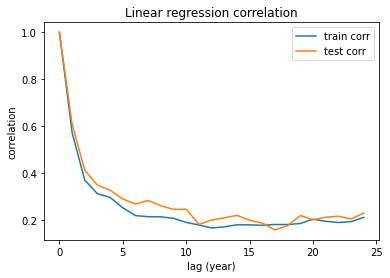

In [9]:
plt.plot(leads, corr_grid_train)
plt.plot(leads, corr_grid_test)
plt.title('Linear regression correlation')
plt.legend(['train corr','test corr'])
plt.xlabel('lag (year)')
plt.ylabel('correlation')

# Loop to train for all combinations of predictors


In [22]:

nvar       = 4
nlead      = len(leads)
netname    = "MLR"
max_epochs = 10 # Filler variable because we didn't use epochs..
expname    = "%s2deg_NAT_%s_nepoch%02i_nens%02i_lead%02i" % (season,netname,max_epochs,ens,len(leads)-1)

# Preallocate Evaluation Metrics...
corr_grid_train = np.zeros((nlead))
corr_grid_test  = np.zeros((nlead))
test_losses     = np.zeros((nlead))
train_losses    = np.zeros((nlead))

for v in range(nvar): # Loop for each variable
    # -------------------
    # Set input variables
    # -------------------
    channels = 1
    start = time.time()
    if v == 0:
        varname = 'SST'
        invars = [sst_normed]
    elif v == 1:
        varname = 'SSS'
        invars = [sss_normed]
    elif v == 2:
        varname = 'PSL'
        invars = [psl_normed]
    elif v == 3:
        channels = 3
        varname = 'ALL'
        invars = [sst_normed,sss_normed,psl_normed]
    outname = "/leadtime_testing_%s_%s.npz" % (varname,expname)
    for lead in tqdm(leads):
        
        y = calc_AMV_index(indexregion,sst_normed[:ens,lead:,:,:],lat,lon)
        y = y.reshape((y.shape[0]*y.shape[1]))[:,None]
        X = np.transpose(
            np.array(invars)[:,:ens,0:tstep-lead,:,:].reshape(channels,(tstep-lead)*ens,nlat,nlon),
            (1,0,2,3))
        X = np.mean(X,axis=(2,3))
        X_train =  X[0:int(np.floor(percent_train*(tstep-lead)*ens)),:].T
        X_val =  X[int(np.floor(percent_train*(tstep-lead)*ens)):,:].T
        y_train =  y[0:int(np.floor(percent_train*(tstep-lead)*ens)),:]
        y_val =  y[int(np.floor(percent_train*(tstep-lead)*ens)):,:] 
        
    
        theta = (inv(X_train @ X_train.T) @ X_train ) @ y_train
        y_pred_train = (theta.T @ X_train).T
        y_pred_val = (theta.T @ X_val).T
        
        test_losses[lead] = np.mean((y_pred_val-y_val)**2)
        train_losses[lead] = np.mean((y_pred_train-y_train)**2)
        
        corr_grid_train[lead] = np.corrcoef(y_pred_train[:,0], y_train[:,0])[0,1]
        corr_grid_test[lead]  = np.corrcoef(y_pred_val[:,0], y_val[:,0])[0,1]
        
        #print("\nCompleted training for %s lead %i of %i" % (varname,lead,len(leads)))
    
    
    np.savez(outpath+"/../../CESM_data/Metrics"+outname,**{
         'train_loss': train_losses,
         'test_loss' : test_losses,
         'test_corr' : corr_grid_test,
         'train_corr': corr_grid_train}
        )
    print("Saved data to %s%s. Finished variable %s"%(outpath,outname,varname))

 12%|█▏        | 3/25 [00:00<00:00, 24.98it/s]

Saved data to /Users/gliu/Downloads/2020_Fall/6.862/Project/predict_amv/Linear_regression/leadtime_testing_SST_Ann2deg_NAT_MLR_nepoch10_nens40_lead24.npz. Finished variable SST


 12%|█▏        | 3/25 [00:00<00:00, 25.11it/s]

Saved data to /Users/gliu/Downloads/2020_Fall/6.862/Project/predict_amv/Linear_regression/leadtime_testing_SSS_Ann2deg_NAT_MLR_nepoch10_nens40_lead24.npz. Finished variable SSS


  8%|▊         | 2/25 [00:00<00:01, 18.15it/s]

Saved data to /Users/gliu/Downloads/2020_Fall/6.862/Project/predict_amv/Linear_regression/leadtime_testing_PSL_Ann2deg_NAT_MLR_nepoch10_nens40_lead24.npz. Finished variable PSL


100%|██████████| 25/25 [00:01<00:00, 18.62it/s]

Saved data to /Users/gliu/Downloads/2020_Fall/6.862/Project/predict_amv/Linear_regression/leadtime_testing_ALL_Ann2deg_NAT_MLR_nepoch10_nens40_lead24.npz. Finished variable ALL
